In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'

weather_data = pd.read_csv('london_weather.csv')
weather_data = weather_data[['date', 'mean_temp']]
weather_data = weather_data.set_index('date', drop = True)
weather_data.index = pd.to_datetime(weather_data.index,format="%Y%m%d")
weather_data = weather_data.fillna(method='ffill')
weather_data.head()


2023-04-04 23:05:49.896006: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,mean_temp
date,
1979-01-01,-4.1
1979-01-02,-2.6
1979-01-03,-2.8
1979-01-04,-2.6
1979-01-05,-0.8


Text(0, 0.5, 'Temp')

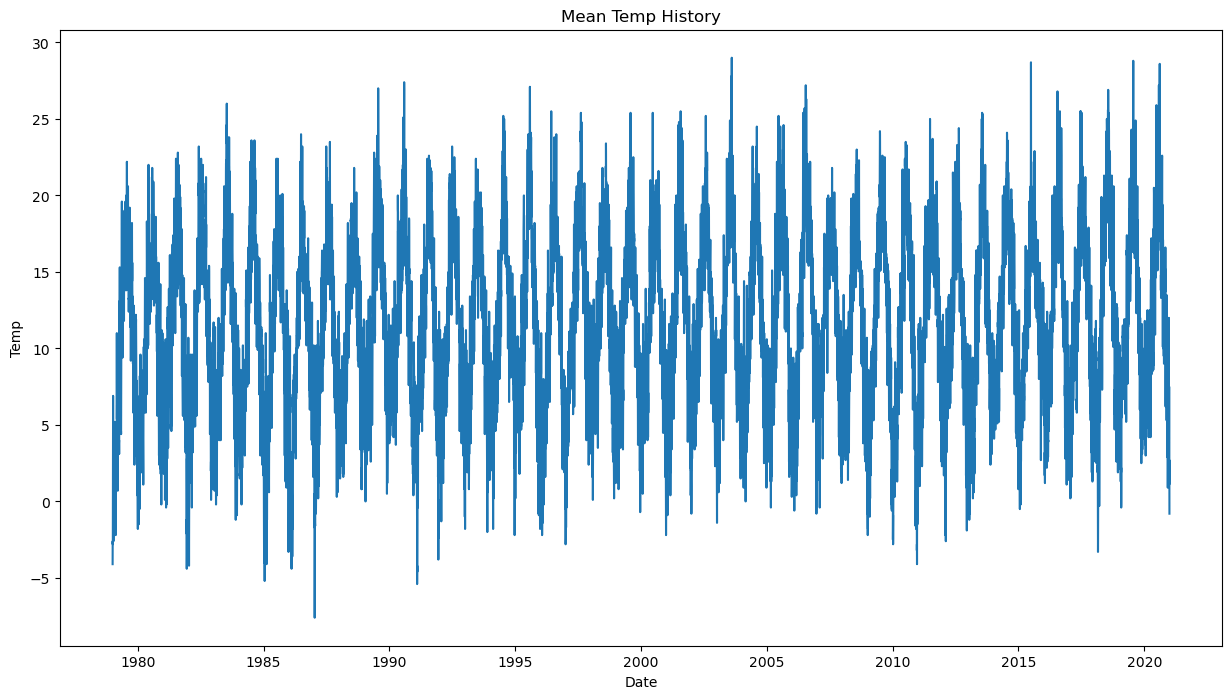

In [2]:
plt.figure(figsize=(15, 8))
plt.title('Mean Temp History')
plt.plot(weather_data['mean_temp'])
plt.xlabel('Date')
plt.ylabel('Temp')

In [11]:
#close_prices = stock_data['Price']
values = weather_data.values
training_data_len = math.ceil(len(values)*0.8 )

#scaler = MinMaxScaler(feature_range=(0,1))
#scaled_data = scaler.fit_transform(values.reshape(-1,1))

#train_data = scaled_data[0: training_data_len, :]
values = values.reshape(-1,1)
train_data = values[0: training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
test_data = values[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
model = keras.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 50,977
Trainable params: 50,977
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 8, epochs=10)

Epoch 1/10
1527/1527 [==============================] - 10s 6ms/step - loss: 6.7366
Epoch 2/10
1527/1527 [==============================] - 8s 6ms/step - loss: 3.7762
Epoch 3/10
1527/1527 [==============================] - 8s 6ms/step - loss: 3.7619
Epoch 4/10
1527/1527 [==============================] - 8s 6ms/step - loss: 3.6988
Epoch 5/10
1527/1527 [==============================] - 9s 6ms/step - loss: 3.6797
Epoch 6/10
1527/1527 [==============================] - 9s 6ms/step - loss: 3.6284
Epoch 7/10
1527/1527 [==============================] - 9s 6ms/step - loss: 3.5913
Epoch 8/10
1527/1527 [==============================] - 9s 6ms/step - loss: 3.5691
Epoch 9/10
1527/1527 [==============================] - 8s 5ms/step - loss: 3.5434
Epoch 10/10
1527/1527 [==============================] - 9s 6ms/step - loss: 3.5271


In [15]:
predictions = model.predict(x_test)
#predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

96/96 [==============================] - 1s 2ms/step


0.13169411194099132

/tmp/ipykernel_47347/3905566851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


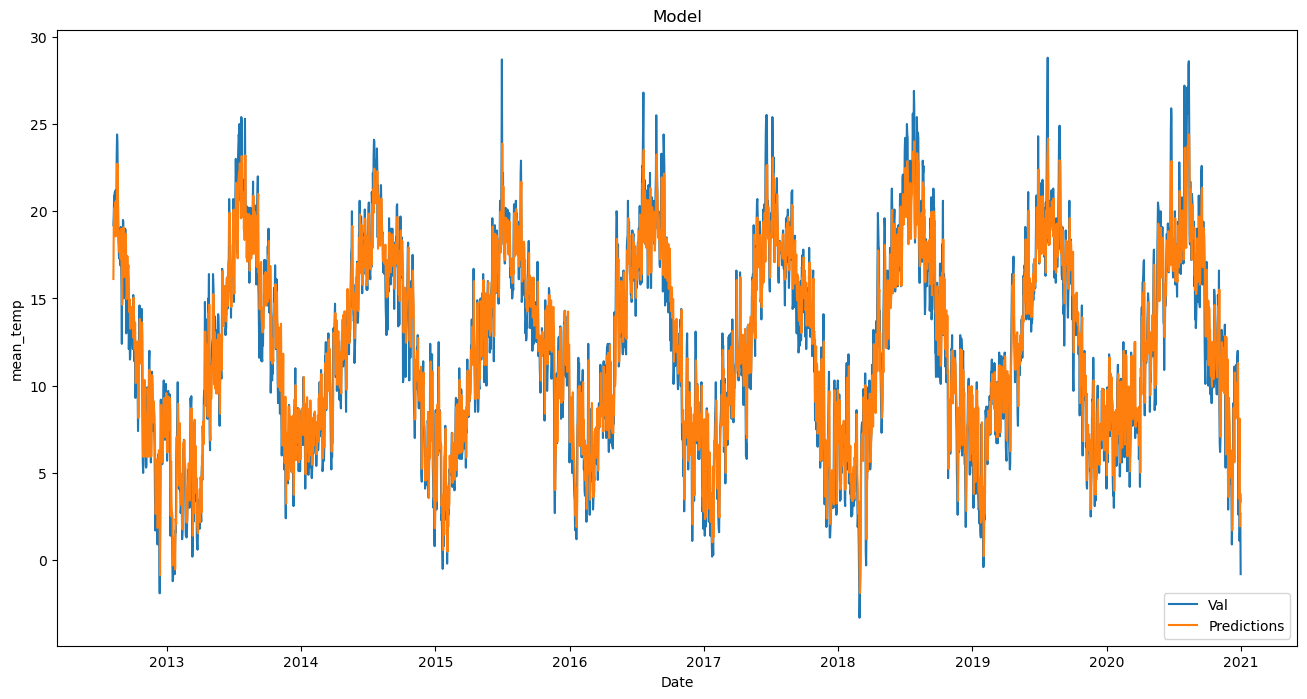

In [16]:
data = weather_data.filter(['mean_temp'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('mean_temp')
#plt.plot(train)
plt.plot(validation[['mean_temp', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

In [17]:
# generate the multi-step forecasts
n_future = 365*3
y_future = []

x_pred = x_test[-1:, :, :]  # last observed input sequence
y_pred = y_test[-1]         # last observed target value

for i in range(n_future):

    # feed the last forecast back to the model as an input
    x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

    # generate the next forecast
    y_pred = model.predict(x_pred)

    # save the forecast
    y_future.append(y_pred.flatten()[0])

# transform the forecasts back to the original scale
y_future = np.array(y_future).reshape(-1, 1)
#y_future = scaler.inverse_transform(y_future)

1/1 [==============================] - 0s 10ms/step


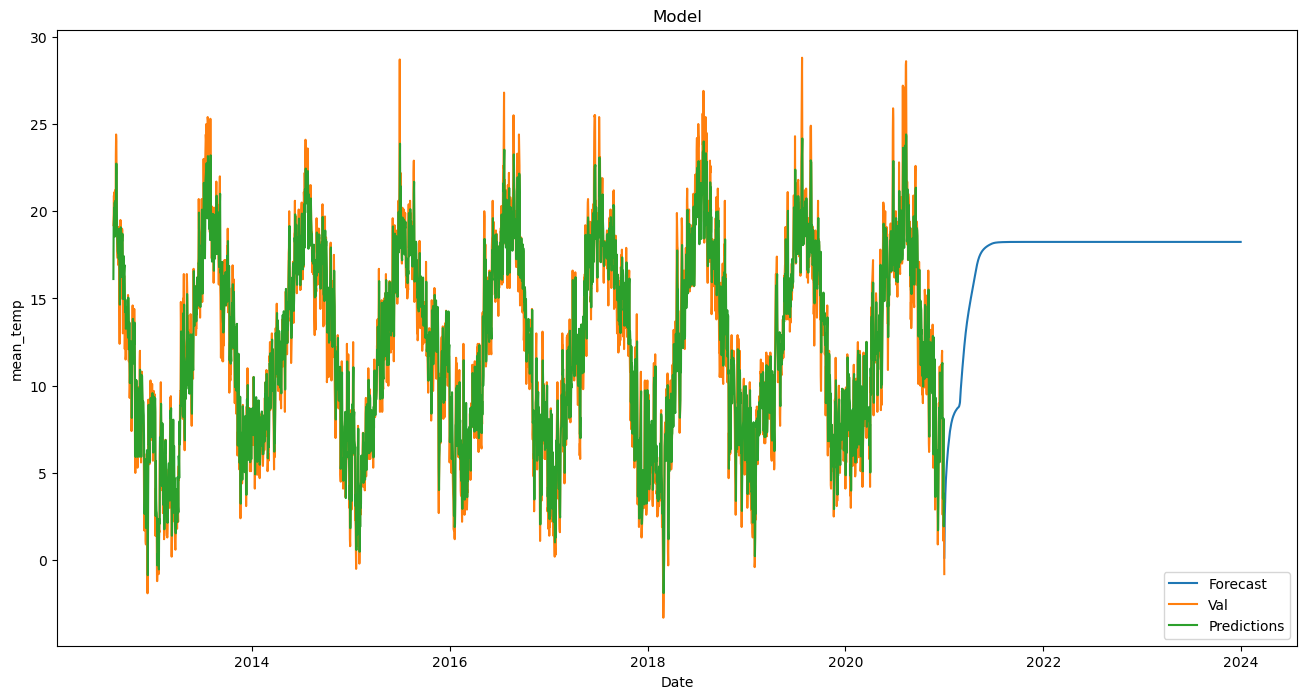

In [18]:
df_future = pd.DataFrame(columns=['Date', 'Forecast'])
df_future['Date'] = pd.date_range(start='2020-12-31', periods=n_future)
df_future['Forecast'] = y_future.flatten()
df_future = df_future.set_index('Date')

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('mean_temp')
plt.plot(df_future)
plt.plot(validation[['mean_temp', 'Predictions']])
plt.legend(['Forecast','Val', 'Predictions'], loc='lower right')
plt.show()

In [11]:
df_future

,Forecast
Date,
2020-12-31,0.200009
2021-01-01,1.785464
2021-01-02,3.351461
2021-01-03,4.608507
2021-01-04,5.366273
...,...
2021-12-26,11.246427
2021-12-27,11.425521
2021-12-28,11.600007
